In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
import polars as pl
import polars.selectors as cs
from copairs.map import average_precision, mean_average_precision
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from features_engineering import features_drop_corr

# 1) Get features and Scale

In [12]:
metadata_df = pd.read_csv("target2_eq_moa2_metadata", index_col="ID") 
features_df = pd.read_csv("target2_eq_moa2_features", index_col="ID") 
nan_col = features_df.columns[features_df.isna().sum(axis=0) > 0]
nan_col, len(nan_col)
inf_col = features_df.columns[(features_df == np.inf).sum(axis=0) > 0]
inf_col, len(inf_col)
features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
                                            ((features_df == np.inf).sum(axis=0) == 0) & 
                                            (features_df.std() != 0)]]
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa"]))
features_df = features_df.sort_index().reset_index(drop=True)
metadata_df = metadata_df.sort_index().reset_index()
metadata_df = metadata_df.assign(
    trt_dmso=metadata_df["pert_iname"].where(metadata_df["pert_iname"] == "DMSO", other="trt"))

In [13]:
features_df = features_drop_corr(threshold=0.95).fit_transform(features_df)
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

# 2) UMAP

In [150]:
mask = np.ones(len(metadata_df["Micro_id"])).astype(bool)# == 2
model_umap = umap.UMAP()
features_df_umap = model_umap.fit_transform(features_df[mask])

Text(0.5, 1.0, 'UMAP - Batch')

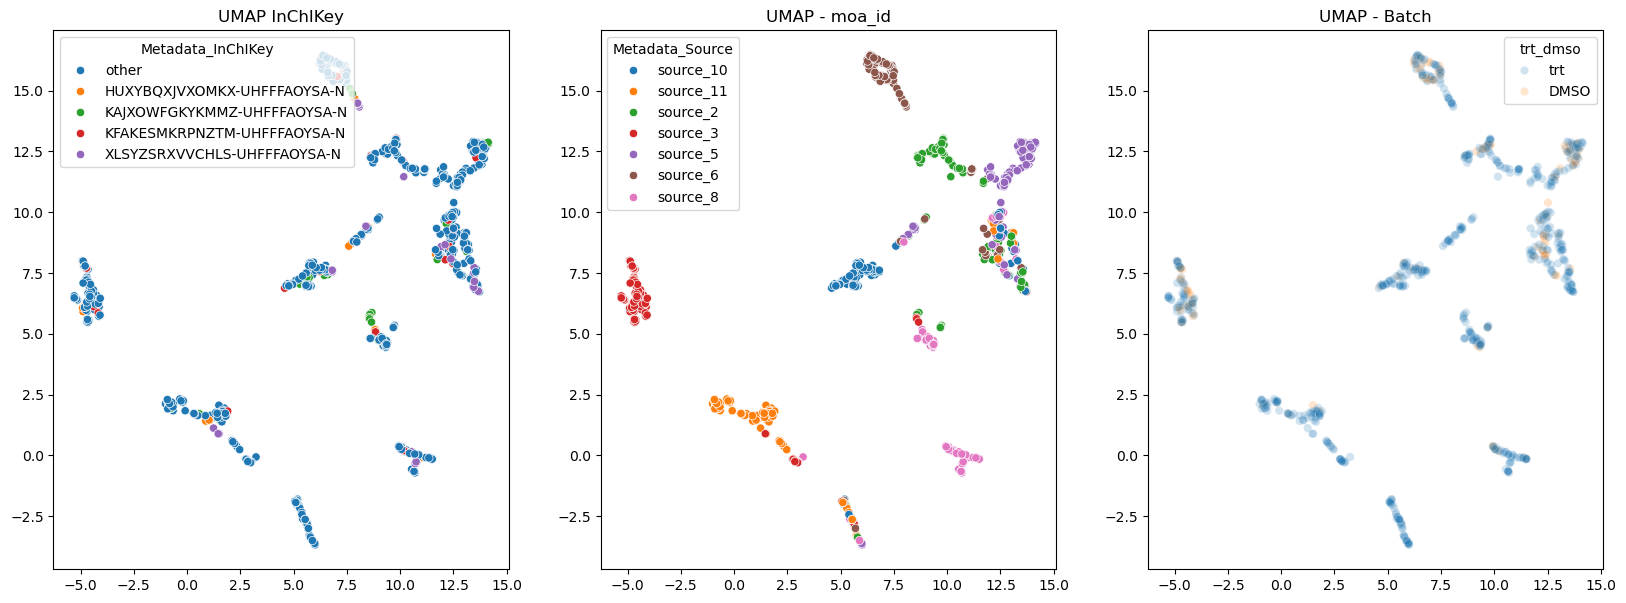

In [154]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
axes = axes.flatten()


sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["Metadata_InChIKey"].where(metadata_df[mask]["moa_id"]==0, other="other"),
                ax=axes[0],
                palette="tab10")
axes[0].set_title("UMAP InChIKey")
#axes[0].get_legend().remove()

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["Metadata_Source"],
                ax=axes[1], 
                palette="tab10")
axes[1].set_title("UMAP - moa_id")

sns.scatterplot(x=features_df_umap[:,0],
                y=features_df_umap[:,1],
                hue=metadata_df[mask]["trt_dmso"],
                alpha=0.2,
                ax=axes[2], 
                palette="tab10")
axes[2].set_title(f"UMAP - Batch")

# 3) Check Phenotypic activity

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

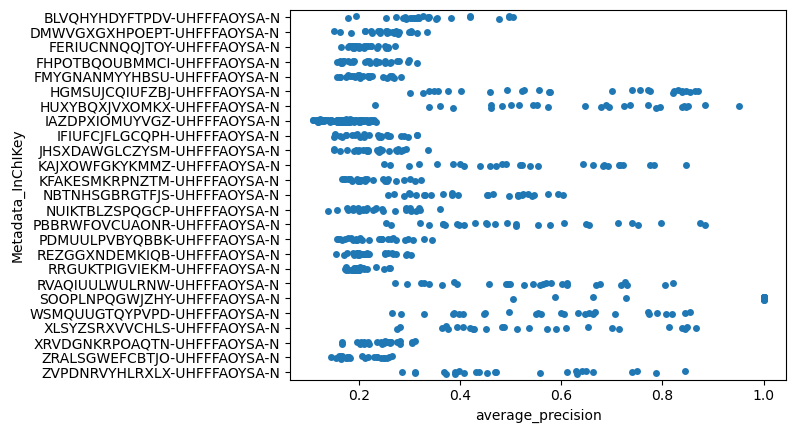

In [155]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = ["ID"]
neg_sameby = []
neg_diffby = ["trt_dmso"]
batch_size = 20000


result = average_precision(
    metadata_df,
    features_df,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
result = result[result["trt_dmso"] != "DMSO"]

In [156]:
mAP = mean_average_precision(result, ["ID"], null_size=10000, threshold=0.05, seed=42)
mAP["-log10(p-value)"] = -mAP["corrected_p_value"].apply(np.log10)
mAP[mAP["below_corrected_p"] == True]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/659 [00:00<?, ?it/s]

,ID,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
0,0,0.419048,0.0006,0.001883,True,True,2.725226
1,1,0.418366,0.0006,0.001883,True,True,2.725226
2,2,0.477544,0.0001,0.000340,True,True,3.468960
3,3,0.496541,0.0001,0.000340,True,True,3.468960
4,4,0.496711,0.0001,0.000340,True,True,3.468960
...,...,...,...,...,...,...,...
653,769,0.787494,0.0001,0.000340,True,True,3.468960
655,771,0.844296,0.0001,0.000340,True,True,3.468960
656,772,0.662456,0.0001,0.000340,True,True,3.468960
657,773,0.630928,0.0001,0.000340,True,True,3.468960


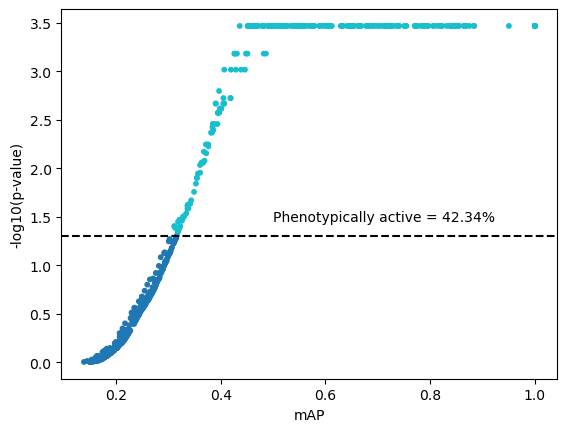

In [157]:
active_ratio = mAP.below_corrected_p.mean()

plt.scatter(data=mAP, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [160]:
count_per_pert_moa

Metadata_InChIKey,1,3,0,2,4,5,6
str,u32,u32,u32,u32,u32,u32,u32
"""BLVQHYHDYFTPDV…",16,null,null,null,null,null,null
"""PBBRWFOVCUAONR…",null,26,null,null,null,null,null
"""XLSYZSRXVVCHLS…",null,null,24,null,null,null,null
"""SOOPLNPQGWJZHY…",28,null,null,null,null,null,null
"""ZVPDNRVYHLRXLX…",null,24,null,null,null,null,null
"""KAJXOWFGKYKMMZ…",null,null,25,null,null,null,null
"""WSMQUUGTQYPVPD…",null,null,null,26,null,null,null
"""IAZDPXIOMUYVGZ…",null,null,null,null,116,null,null
"""NBTNHSGBRGTFJS…",null,22,null,null,null,null,null


In [158]:
mask_active = (metadata_df["ID"].isin(
    mAP[mAP["below_corrected_p"]]["ID"]) 
+ (metadata_df["trt_dmso"] == "DMSO"))
metadata_df_active = metadata_df[mask_active]
features_df_active = features_df[mask_active]

In [159]:
count_per_pert_moa = (pl.DataFrame(metadata_df_active).group_by(["moa_id","Metadata_InChIKey"])
 .agg(pl.col("Metadata_InChIKey").count().alias("count_per_pert_moa"))
 .pivot(columns="moa_id",
       index="Metadata_InChIKey",
       values="count_per_pert_moa"))
mask_active_keep = metadata_df_active["Metadata_InChIKey"].isin(count_per_pert_moa.filter(
    count_per_pert_moa.select(pl.all().exclude("Metadata_InChIKey")).sum_horizontal() > 10)
                                                                .select("Metadata_InChIKey").to_series())


metadata_df_active = metadata_df_active[mask_active_keep]
features_df_active = features_df_active[mask_active_keep]

# 3) Check Consistency within MoA

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/copairs/compute.py:111: RuntimeWarning: invalid value encountered in divide
  ap_scores = np.add.reduceat(pr_k * rel_k_list, cutoffs) / num_pos


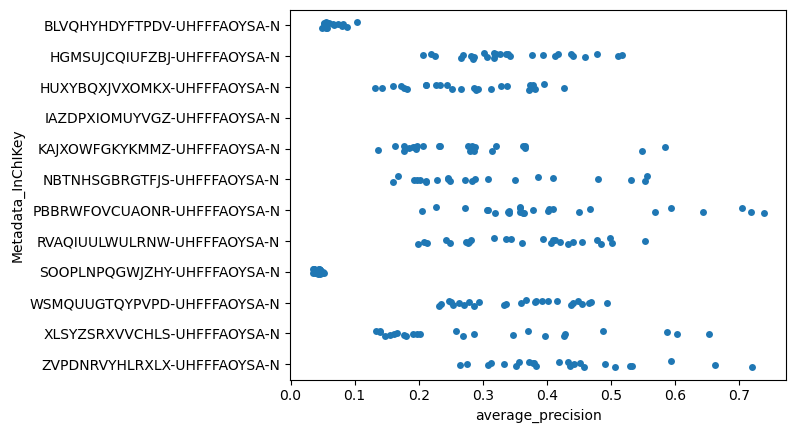

In [162]:
pos_sameby = ["moa_id"]  # We want to match perturbations
pos_diffby = ["Metadata_InChIKey"]
neg_sameby = []
neg_diffby = ["moa_id"]
batch_size = 20000


result = average_precision(
    metadata_df_active,
    features_df_active,#.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
result = result[result["trt_dmso"] != "DMSO"]

In [163]:
mAP = mean_average_precision(result, ["Metadata_InChIKey"], null_size=10000, threshold=0.05, seed=42)
mAP["-log10(p-value)"] = -mAP["corrected_p_value"].apply(np.log10)
mAP[mAP["below_corrected_p"] == True]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

,Metadata_InChIKey,mean_average_precision,p_value,corrected_p_value,below_p,below_corrected_p,-log10(p-value)
1,HGMSUJCQIUFZBJ-UHFFFAOYSA-N,0.347650,0.0001,0.000220,True,True,3.657621
2,HUXYBQXJVXOMKX-UHFFFAOYSA-N,0.275089,0.0002,0.000244,True,True,3.611863
3,KAJXOWFGKYKMMZ-UHFFFAOYSA-N,0.273766,0.0002,0.000244,True,True,3.611863
4,NBTNHSGBRGTFJS-UHFFFAOYSA-N,0.305660,0.0002,0.000244,True,True,3.611863
5,PBBRWFOVCUAONR-UHFFFAOYSA-N,0.420372,0.0001,0.000220,True,True,3.657621
6,RVAQIUULWULRNW-UHFFFAOYSA-N,0.363779,0.0001,0.000220,True,True,3.657621
8,WSMQUUGTQYPVPD-UHFFFAOYSA-N,0.353175,0.0001,0.000220,True,True,3.657621
9,XLSYZSRXVVCHLS-UHFFFAOYSA-N,0.295827,0.0002,0.000244,True,True,3.611863
10,ZVPDNRVYHLRXLX-UHFFFAOYSA-N,0.432540,0.0001,0.000220,True,True,3.657621


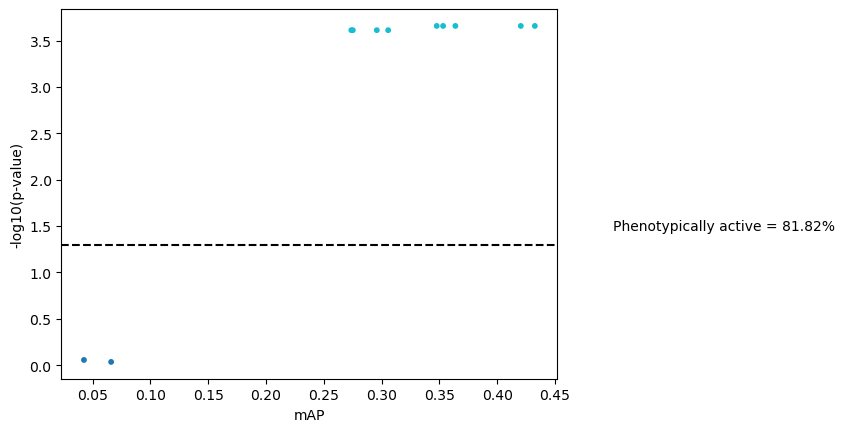

In [164]:
active_ratio = mAP.below_corrected_p.mean()

plt.scatter(data=mAP, x="mean_average_precision", y="-log10(p-value)", c="below_corrected_p", cmap="tab10", s=10)
plt.xlabel("mAP")
plt.ylabel("-log10(p-value)")
plt.axhline(-np.log10(0.05), color="black", linestyle="--")
plt.text(0.5, 1.5, f"Phenotypically active = {100*active_ratio:.2f}%", va="center", ha="left")
plt.show()

In [165]:
mask_active = (metadata_df["Metadata_InChIKey"].isin(
    mAP[mAP["below_corrected_p"]]["Metadata_InChIKey"]) 
+ (metadata_df["trt_dmso"] == "DMSO"))
metadata_df_active = metadata_df[mask_active]
features_df_active = features_df[mask_active]

In [166]:
count_per_pert_moa = (pl.DataFrame(metadata_df_active).group_by(["moa_id","Metadata_InChIKey"])
 .agg(pl.col("Metadata_InChIKey").count().alias("count_per_pert_moa"))
 .pivot(columns="moa_id",
       index="Metadata_InChIKey",
       values="count_per_pert_moa"))

In [167]:
count_per_pert_moa

Metadata_InChIKey,3,0,2,4
str,u32,u32,u32,u32
"""ZVPDNRVYHLRXLX…",25,null,null,null
"""PBBRWFOVCUAONR…",28,null,null,null
"""XLSYZSRXVVCHLS…",null,26,null,null
"""HGMSUJCQIUFZBJ…",null,null,28,null
"""IAZDPXIOMUYVGZ…",null,null,null,116
"""RVAQIUULWULRNW…",null,null,28,null
"""NBTNHSGBRGTFJS…",28,null,null,null
"""HUXYBQXJVXOMKX…",null,27,null,null
"""WSMQUUGTQYPVPD…",null,null,28,null


# Other Test

In [2]:
import Data_filtering.plot_distribution_table as pdt

In [3]:
metadata_df = pd.read_csv("target2_filtered_metadata", index_col="ID") 
features_df = pd.read_csv("target2_filtered_features", index_col="ID") 
nan_col = features_df.columns[features_df.isna().sum(axis=0) > 0]
nan_col, len(nan_col)
inf_col = features_df.columns[(features_df == np.inf).sum(axis=0) > 0]
inf_col, len(inf_col)
features_df = features_df[features_df.columns[(features_df.isna().sum(axis=0) == 0) & 
                                            ((features_df == np.inf).sum(axis=0) == 0) & 
                                            (features_df.std() != 0)]]
metadata_df = metadata_df.assign(moa_id=LabelEncoder().fit_transform(metadata_df["moa_reduced"]))
features_df = features_df.sort_index().reset_index(drop=True)
metadata_df = metadata_df.sort_index().reset_index()
metadata_df = metadata_df.assign(
    trt_dmso=metadata_df["pert_iname"].where(metadata_df["pert_iname"] == "DMSO", other="trt"))

/home/hhakem/projects/counterfactuals_projects/.venv/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [10]:
pl.DataFrame(metadata_df).filter(pl.col("trt_dmso") != "DMSO").select(pl.all().n_unique())

ID,Metadata_JCP2022,Metadata_InChIKey,Metadata_InChI,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Batch,Metadata_PlateType,Metadata_Microscope_Name,Metadata_Widefield_vs_Confocal,Metadata_Excitation_Type,Metadata_Objective_NA,Metadata_Filter_Configuration,Micro_id,pert_iname,target,pert_type,control_type,smiles,InChI,moa,moa_right,moa_reduced,moa_id,trt_dmso
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
10868,282,282,282,8,750,372,104,2,5,2,2,2,6,7,282,159,2,5,282,282,194,171,171,171,1


In [ ]:
features_df = features_drop_corr(threshold=0.95).fit_transform(features_df)
dmso_scaler = RobustScaler().fit(features_df[metadata_df["trt_dmso"] == "DMSO"])
features_df = dmso_scaler.transform(features_df)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2346 [00:00<?, ?it/s]

<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

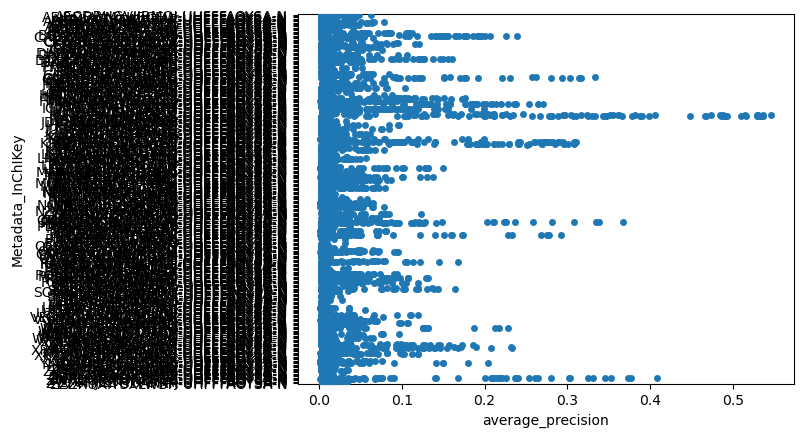

In [33]:
pos_sameby = ["Metadata_InChIKey"]  # We want to match perturbations
pos_diffby = []
neg_sameby = []
neg_diffby = ["moa_id"]
batch_size = 25000


result = average_precision(
    metadata_df_trt,
    features_df_trt.to_numpy(),
    pos_sameby,
    pos_diffby,
    neg_sameby,
    neg_diffby,
    batch_size,
)

sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey")
# result = pl.DataFrame(
#     result
# )  # We convert back to polars because we prefer how it prints dataframes
# result#.head()

<Axes: xlabel='average_precision', ylabel='Metadata_InChIKey'>

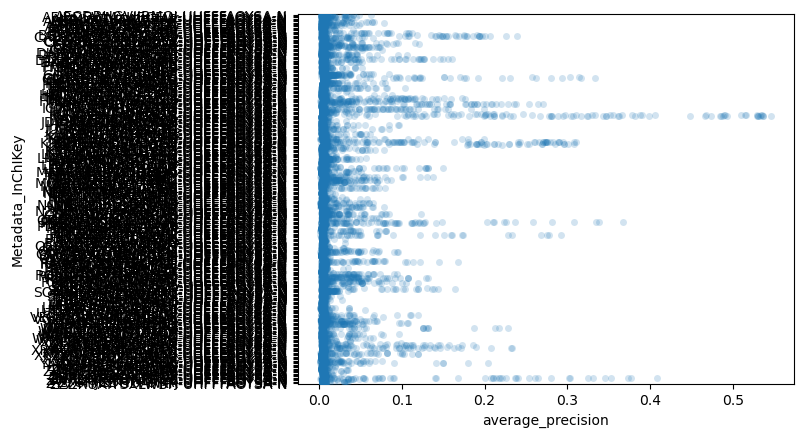

In [51]:
sns.stripplot(data=result, x="average_precision", y="Metadata_InChIKey", alpha=0.2)

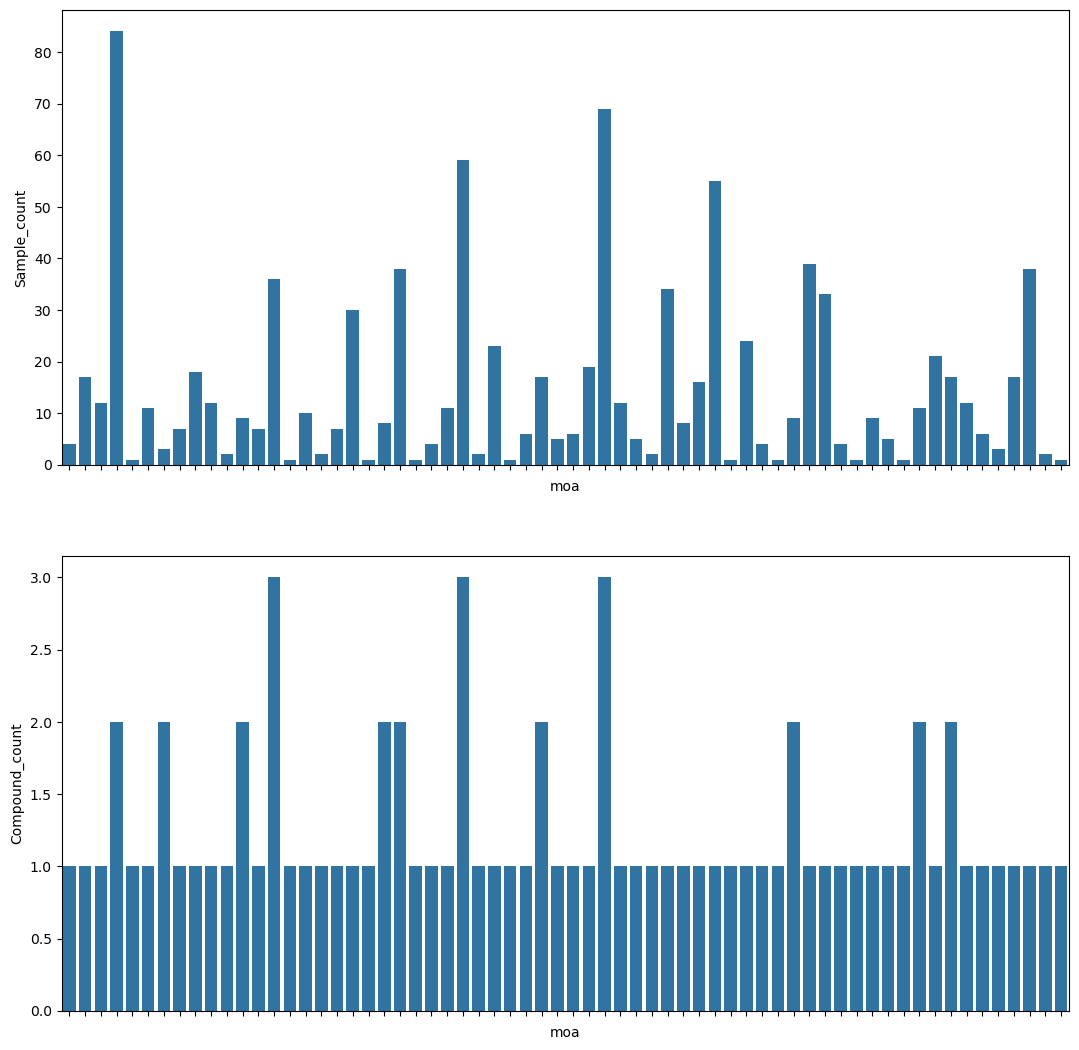

In [52]:
pdt.moa_distribution(pl.DataFrame(metadata_df_trt[result["average_precision"] > 0.05]))